In [22]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime
import boto3
import psycopg2
import configparser

### Creación del modelo de datos

In [23]:
rdsIdentifier = 'super-db' #nombre de la instancia

#### Cargamos archivo de configuraciones

In [24]:
config = configparser.ConfigParser()
config.read('escec2.cfg')



['escec2.cfg']

### Creamos Instancia de S3 y RDS

In [25]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                    aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                    region_name='us-east-1')

#### Verificamos Instancias de RDS disponibles

In [26]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['super-db']


#### Creación de Servicio RDS

In [27]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS_MYSQL', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="mysql",
            MasterUsername=config.get('RDS_MYSQL', 'DB_USER'),
            MasterUserPassword=config.get('RDS_MYSQL', 'DB_PASSWORD'),
            BackupRetentionPeriod=0, #para evitar los backups y que nos cobren
            Port=int(config.get('RDS_MYSQL', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

La Instancia de Base de Datos ya Existe.


##### Obtenemos URL del Host

In [28]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

super-db.cio9bwv4hzyt.us-east-1.rds.amazonaws.com


#### Conexión a Base de Datos desde Python

In [29]:
import querie_super

In [30]:
import querie_super
import mysql.connector as mysqlC
try:
    myDw = mysqlC.connect(
    host=RDS_HOST, 
    user=config.get('RDS_MYSQL', 'DB_USER'),
    password=config.get('RDS_MYSQL', 'DB_PASSWORD'),
    database=config.get('RDS_MYSQL', 'DB_NAME')
    )

    mycursor = myDw.cursor()
    mycursor.execute(querie_super.DDL_QUERY_SUPER, multi=True)
    myDw.commit()
    print("Data Warehouse Creado Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

#Aunque nos de un error, verificar en DBeaver si se creó el query y las tablas

ERROR: Error al crear la base de datos.
1050 (42S01): Table 'Ubicacion' already exists


#### Driver MYSQL


In [33]:
mysql_driver = f"""mysql+pymysql://{config.get('RDS_MYSQL', 'DB_USER')}:{config.get('RDS_MYSQL', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS_MYSQL', 'DB_PORT')}/{config.get('RDS_MYSQL', 'DB_NAME')}"""  

In [34]:
sql_query = 'SELECT * FROM Ubicacion;'
df_ubicacion = pd.read_sql(sql_query, mysql_driver)
df_ubicacion.head()

,ID_Ubicacion,Codigo_postal,Pais,Estado,Ciudad
0,1,55407.0,United States,Minnesota,Minneapolis
1,2,94109.0,United States,California,San Francisco
2,3,94122.0,United States,California,San Francisco
3,4,78664.0,United States,Texas,Round Rock
4,5,10011.0,United States,New York,New York City


#### Creamos el bucket y cargamos los datos

In [12]:
# Nombre del bucket
bucket_name = 'datos-super-edgar'

In [13]:
# Creación del bucket
s3.create_bucket(Bucket=bucket_name)

# documentos
file_name = 'dim_date.csv'
file_name2 = 'SuperStoreOutput.csv'

# Nombre del archivo csv en el bucket
s3_file_name = 'dim_date_super.csv'
s3_file_name2 = 'SuperStoreOutput.csv'

# Metiendo los archivos al bucket
s3.upload_file(file_name, bucket_name, s3_file_name)
s3.upload_file(file_name2, bucket_name, s3_file_name2)

#Acabo de cargar los datos de fechas y la base de datos principal



NameError: name 'bucket_name' is not defined

In [14]:
for bucket in s3.buckets.all():
    S3_BUCKET_NAME = bucket.name
    print(bucket.name)

bucket-v-23000966
datos-super-edgar


In [15]:
#extraemos todo lo que está en el bucket
remoteFileList = []
for objt in s3.Bucket(bucket_name).objects.all():
    remoteFileList.append(objt.key)

remoteFileList

['SuperStoreOutput.csv', 'dim_date_super.csv']

#### Leemos archivo del bucket de S3

In [16]:
# Cargamos el data frame de supermercado
file1 = s3.Bucket(bucket_name).Object('SuperStoreOutput.csv').get()
tabla_super= pd.read_csv(file1['Body'])
tabla_super.head() 

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1160,CA-2018-147039,6/29/2018 12:00:00 AM,7/4/2018 12:00:00 AM,Standard Class,AA-10315,Alex Avila,Consumer,United States,Minneapolis,...,55407.0,Central,OFF-AP-10000576,Office Supplies,Appliances,"Belkin 325VA UPS Surge Protector, 6'",362.94,3,0.0,90.74
1,1161,CA-2018-147039,6/29/2018 12:00:00 AM,7/4/2018 12:00:00 AM,Standard Class,AA-10315,Alex Avila,Consumer,United States,Minneapolis,...,55407.0,Central,OFF-BI-10004654,Office Supplies,Binders,Avery Binding System Hidden Tab Executive Styl...,11.54,2,0.0,5.77
2,1300,CA-2016-121391,10/4/2016 12:00:00 AM,10/7/2016 12:00:00 AM,First Class,AA-10315,Alex Avila,Consumer,United States,San Francisco,...,94109.0,West,OFF-ST-10001590,Office Supplies,Storage,Tenex Personal Project File with Scoop Front D...,26.96,2,0.0,7.01
3,2230,CA-2015-128055,3/31/2015 12:00:00 AM,4/5/2015 12:00:00 AM,Standard Class,AA-10315,Alex Avila,Consumer,United States,San Francisco,...,94122.0,West,OFF-BI-10004390,Office Supplies,Binders,GBC DocuBind 200 Manual Binding Machine,673.57,2,0.2,252.59
4,2231,CA-2015-128055,3/31/2015 12:00:00 AM,4/5/2015 12:00:00 AM,Standard Class,AA-10315,Alex Avila,Consumer,United States,San Francisco,...,94122.0,West,OFF-AP-10002765,Office Supplies,Appliances,Fellowes Advanced Computer Series Surge Protec...,52.98,2,0.0,14.83


In [17]:
# Cargamos el data frame de fechas
file2 = s3.Bucket(bucket_name).Object('dim_date_super.csv').get()
fechas= pd.read_csv(file2['Body'])
fechas.head()

,date_key,full_date,day_of_week,day_num_in_month,day_num_overall,day_name,day_abbrev,weekday_flag,week_num_in_year,week_num_overall,...,month_name,month_abbrev,quarter,year,yearmo,fiscal_month,fiscal_quarter,fiscal_year,last_day_in_month_flag,same_day_year_ago_date
0,20150101,1/1/2015,4,1,1,Thursday,Thu,Weekday,1,1,...,January,Jan,1,2015,201501,7,3,2015,Not Month End,1/1/2014
1,20150102,1/2/2015,5,2,2,Friday,Fri,Weekday,1,1,...,January,Jan,1,2015,201501,7,3,2015,Not Month End,1/2/2014
2,20150103,1/3/2015,6,3,3,Saturday,Sat,Weekend,1,1,...,January,Jan,1,2015,201501,7,3,2015,Not Month End,1/3/2014
3,20150104,1/4/2015,7,4,4,Sunday,Sun,Weekend,1,1,...,January,Jan,1,2015,201501,7,3,2015,Not Month End,1/4/2014
4,20150105,1/5/2015,1,5,5,Monday,Mon,Weekday,2,2,...,January,Jan,1,2015,201501,7,3,2015,Not Month End,1/5/2014


### Limpiamos las tablas para ser ingresadas a las dimensiones y hechos (Procesamiento)

#### Creamos tabla para cliente

In [18]:
tabla_cl = tabla_super.loc[:, ['Customer ID','Customer Name', 'Segment']]

nombres_cl = {'Customer ID': 'Id_cliente', 'Customer Name': 'Nombre', 'Segment': 'Segmento'}
tabla_cl.rename(columns = nombres_cl, inplace = True)

tabla_clientes= tabla_cl.drop_duplicates()
tabla_clientes.head()

,Id_cliente,Nombre,Segmento
0,AA-10315,Alex Avila,Consumer
11,AA-10375,Allen Armold,Consumer
26,AA-10480,Andrew Allen,Consumer
38,AA-10645,Anna Andreadi,Consumer
56,AB-10015,Aaron Bergman,Consumer


In [19]:
#insertamos en dimension de cliente
tabla_clientes.to_sql('Cliente', mysql_driver, index=False, if_exists='append')

793

#### Creamos tabla para producto

In [20]:
tabla_pr = tabla_super.loc[:, ['Product ID','Category', 'Sub-Category', 'Product Name']]

nombres_pr = {'Product ID': 'Id_producto', 'Category': 'Categoria', 'Sub-Category': 'Subcategoria','Product Name': 'Nombre'}
tabla_pr.rename(columns = nombres_pr, inplace = True)

tabla_producto= tabla_pr.drop_duplicates()
tabla_producto.head()


,Id_producto,Categoria,Subcategoria,Nombre
0,OFF-AP-10000576,Office Supplies,Appliances,"Belkin 325VA UPS Surge Protector, 6'"
1,OFF-BI-10004654,Office Supplies,Binders,Avery Binding System Hidden Tab Executive Styl...
2,OFF-ST-10001590,Office Supplies,Storage,Tenex Personal Project File with Scoop Front D...
3,OFF-BI-10004390,Office Supplies,Binders,GBC DocuBind 200 Manual Binding Machine
4,OFF-AP-10002765,Office Supplies,Appliances,Fellowes Advanced Computer Series Surge Protec...


In [21]:
#insertamos en dimension de producto
tabla_producto.to_sql('Producto', mysql_driver, index=False, if_exists='append')

1894

#### Creamos tabla para Ubicación

In [22]:
tabla_ub = tabla_super.loc[:, ['Postal Code','Country', 'State', 'City']]

nombres_ub = {'Postal Code': 'Codigo_postal', 'Country': 'Pais', 'State': 'Estado','City': 'Ciudad'}
tabla_ub.rename(columns = nombres_ub, inplace = True)


tabla_ubicacion= tabla_ub.drop_duplicates()
tabla_ubicacion.head()

,Codigo_postal,Pais,Estado,Ciudad
0,55407.0,United States,Minnesota,Minneapolis
2,94109.0,United States,California,San Francisco
3,94122.0,United States,California,San Francisco
5,78664.0,United States,Texas,Round Rock
9,10011.0,United States,New York,New York City


In [23]:
#insertamos en dimension de producto
tabla_ubicacion.to_sql('Ubicacion', mysql_driver, index=False, if_exists='append')

632

#### Creamos tabla para fechas de orden

In [24]:
tabla_fechas = fechas.loc[:, ['date_key', 'full_date','day_of_week', 'day_num_in_month', 'day_name', 'weekday_flag','month_name','month_abbrev','year']]


nombres_f = {'date_key': 'date_key', 'full_date': 'full_date','day_of_week':'day_of_week', 'day_num_in_month': 'day_num_in_month', 'day_name': 'day_name', 'weekday_flag':'weekday_flag','month_name': 'month_name','month_abbrev': 'month_abbrev','year': '_year'}
tabla_fechas.rename(columns = nombres_f, inplace = True)

aux_fechas = pd.to_datetime(tabla_fechas['full_date'])
tabla_fechas['Full_Date_Order'] = aux_fechas

tabla_fechas = tabla_fechas.drop(columns=['full_date'])

tabla_fechas.head()


,date_key,day_of_week,day_num_in_month,day_name,weekday_flag,month_name,month_abbrev,_year,Full_Date_Order
0,20150101,4,1,Thursday,Weekday,January,Jan,2015,2015-01-01
1,20150102,5,2,Friday,Weekday,January,Jan,2015,2015-01-02
2,20150103,6,3,Saturday,Weekend,January,Jan,2015,2015-01-03
3,20150104,7,4,Sunday,Weekend,January,Jan,2015,2015-01-04
4,20150105,1,5,Monday,Weekday,January,Jan,2015,2015-01-05


In [25]:
#insertamos en dimension de producto
tabla_fechas.to_sql('Fechas_orden', mysql_driver, index=False, if_exists='append')

2191

In [26]:
sql_query = 'SELECT * FROM Ubicacion;'
dimubicacion = pd.read_sql(sql_query, mysql_driver)
dimubicacion.head()

,ID_Ubicacion,Codigo_postal,Pais,Estado,Ciudad
0,1,55407.0,United States,Minnesota,Minneapolis
1,2,94109.0,United States,California,San Francisco
2,3,94122.0,United States,California,San Francisco
3,4,78664.0,United States,Texas,Round Rock
4,5,10011.0,United States,New York,New York City


In [27]:
join_table = tabla_super.merge(dimubicacion, 
                                                                                               left_on='Postal Code',
                                                                                               right_on='Codigo_postal',
                                                                                               how='inner')

join_table

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product Name,Sales,Quantity,Discount,Profit,ID_Ubicacion,Codigo_postal,Pais,Estado,Ciudad
0,1160,CA-2018-147039,6/29/2018 12:00:00 AM,7/4/2018 12:00:00 AM,Standard Class,AA-10315,Alex Avila,Consumer,United States,Minneapolis,...,"Belkin 325VA UPS Surge Protector, 6'",362.94,3,0.0,90.74,1,55407.0,United States,Minnesota,Minneapolis
1,1161,CA-2018-147039,6/29/2018 12:00:00 AM,7/4/2018 12:00:00 AM,Standard Class,AA-10315,Alex Avila,Consumer,United States,Minneapolis,...,Avery Binding System Hidden Tab Executive Styl...,11.54,2,0.0,5.77,1,55407.0,United States,Minnesota,Minneapolis
2,1897,CA-2018-141789,10/3/2018 12:00:00 AM,10/6/2018 12:00:00 AM,First Class,AC-10450,Amy Cox,Consumer,United States,Minneapolis,...,GBC DocuBind TL300 Electric Binding System,1793.98,2,0.0,843.17,1,55407.0,United States,Minnesota,Minneapolis
3,9218,US-2018-118157,11/14/2018 12:00:00 AM,11/17/2018 12:00:00 AM,First Class,AW-10930,Arthur Wiediger,Home Office,United States,Minneapolis,...,Security-Tint Envelopes,15.28,2,0.0,7.49,1,55407.0,United States,Minnesota,Minneapolis
4,6885,CA-2016-120677,5/31/2016 12:00:00 AM,6/4/2016 12:00:00 AM,Standard Class,BD-11320,Bill Donatelli,Consumer,United States,Minneapolis,...,Hon Pagoda Stacking Chairs,2567.84,8,0.0,770.35,1,55407.0,United States,Minnesota,Minneapolis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10028,5413,CA-2018-166856,9/18/2018 12:00:00 AM,9/22/2018 12:00:00 AM,Standard Class,TS-21505,Tony Sayre,Consumer,United States,Clovis,...,Kingston Digital DataTraveler 64GB USB 2.0,101.34,3,0.0,8.11,629,88101.0,United States,New Mexico,Clovis
10029,3216,CA-2018-150189,7/8/2018 12:00:00 AM,7/10/2018 12:00:00 AM,First Class,VG-21790,Vivek Gonzalez,Consumer,United States,San Mateo,...,Avery 485,75.18,6,0.0,35.33,630,94403.0,United States,California,San Mateo
10030,4341,US-2015-129609,3/22/2015 12:00:00 AM,3/22/2015 12:00:00 AM,Same Day,VM-21835,Vivian Mathis,Consumer,United States,Portage,...,Avery Hi-Liter EverBold Pen Style Fluorescent ...,16.28,2,0.0,6.51,631,46368.0,United States,Indiana,Portage
10031,9835,CA-2017-126627,10/10/2017 12:00:00 AM,10/12/2017 12:00:00 AM,First Class,WB-21850,William Brown,Consumer,United States,La Porte,...,"Eldon 400 Class Desk Accessories, Black Carbon",14.00,4,0.6,-6.30,632,77571.0,United States,Texas,La Porte


In [28]:
join_table = join_table.drop(columns=['Region','Country','City','Customer Name','Segment','Ship Date','Ship Mode','Row ID','State','Category','Sub-Category','Product Name','Postal Code','Codigo_postal','Pais','Estado','Ciudad'])
join_table

,Order ID,Order Date,Customer ID,Product ID,Sales,Quantity,Discount,Profit,ID_Ubicacion
0,CA-2018-147039,6/29/2018 12:00:00 AM,AA-10315,OFF-AP-10000576,362.94,3,0.0,90.74,1
1,CA-2018-147039,6/29/2018 12:00:00 AM,AA-10315,OFF-BI-10004654,11.54,2,0.0,5.77,1
2,CA-2018-141789,10/3/2018 12:00:00 AM,AC-10450,OFF-BI-10001359,1793.98,2,0.0,843.17,1
3,US-2018-118157,11/14/2018 12:00:00 AM,AW-10930,OFF-EN-10004459,15.28,2,0.0,7.49,1
4,CA-2016-120677,5/31/2016 12:00:00 AM,BD-11320,FUR-CH-10002320,2567.84,8,0.0,770.35,1
...,...,...,...,...,...,...,...,...,...
10028,CA-2018-166856,9/18/2018 12:00:00 AM,TS-21505,TEC-AC-10004992,101.34,3,0.0,8.11,629
10029,CA-2018-150189,7/8/2018 12:00:00 AM,VG-21790,OFF-LA-10002762,75.18,6,0.0,35.33,630
10030,US-2015-129609,3/22/2015 12:00:00 AM,VM-21835,OFF-AR-10003478,16.28,2,0.0,6.51,631
10031,CA-2017-126627,10/10/2017 12:00:00 AM,WB-21850,FUR-FU-10004963,14.00,4,0.6,-6.30,632


In [29]:
join_table = join_table.merge(tabla_clientes, 
                                                                                               left_on='Customer ID',
                                                                                               right_on='Id_cliente',
                                                                                               how='inner')

join_table

,Order ID,Order Date,Customer ID,Product ID,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente,Nombre,Segmento
0,CA-2018-147039,6/29/2018 12:00:00 AM,AA-10315,OFF-AP-10000576,362.94,3,0.0,90.74,1,AA-10315,Alex Avila,Consumer
1,CA-2018-147039,6/29/2018 12:00:00 AM,AA-10315,OFF-BI-10004654,11.54,2,0.0,5.77,1,AA-10315,Alex Avila,Consumer
2,CA-2016-121391,10/4/2016 12:00:00 AM,AA-10315,OFF-ST-10001590,26.96,2,0.0,7.01,2,AA-10315,Alex Avila,Consumer
3,CA-2015-128055,3/31/2015 12:00:00 AM,AA-10315,OFF-BI-10004390,673.57,2,0.2,252.59,3,AA-10315,Alex Avila,Consumer
4,CA-2015-128055,3/31/2015 12:00:00 AM,AA-10315,OFF-AP-10002765,52.98,2,0.0,14.83,3,AA-10315,Alex Avila,Consumer
...,...,...,...,...,...,...,...,...,...,...,...,...
10028,CA-2018-124205,9/15/2018 12:00:00 AM,TC-21145,TEC-PH-10002115,395.94,6,0.0,102.94,260,TC-21145,Theresa Coyne,Corporate
10029,CA-2018-124205,9/15/2018 12:00:00 AM,TC-21145,OFF-ST-10000934,81.96,2,0.0,0.00,260,TC-21145,Theresa Coyne,Corporate
10030,CA-2018-113558,10/21/2018 12:00:00 AM,PH-18790,FUR-CH-10003379,683.95,3,0.2,42.75,339,PH-18790,Patricia Hirasaki,Home Office
10031,CA-2018-113558,10/21/2018 12:00:00 AM,PH-18790,FUR-FU-10001756,45.70,3,0.2,5.14,339,PH-18790,Patricia Hirasaki,Home Office


In [30]:
join_table = join_table.drop(columns=['Nombre','Segmento','Customer ID'])
join_table

,Order ID,Order Date,Product ID,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente
0,CA-2018-147039,6/29/2018 12:00:00 AM,OFF-AP-10000576,362.94,3,0.0,90.74,1,AA-10315
1,CA-2018-147039,6/29/2018 12:00:00 AM,OFF-BI-10004654,11.54,2,0.0,5.77,1,AA-10315
2,CA-2016-121391,10/4/2016 12:00:00 AM,OFF-ST-10001590,26.96,2,0.0,7.01,2,AA-10315
3,CA-2015-128055,3/31/2015 12:00:00 AM,OFF-BI-10004390,673.57,2,0.2,252.59,3,AA-10315
4,CA-2015-128055,3/31/2015 12:00:00 AM,OFF-AP-10002765,52.98,2,0.0,14.83,3,AA-10315
...,...,...,...,...,...,...,...,...,...
10028,CA-2018-124205,9/15/2018 12:00:00 AM,TEC-PH-10002115,395.94,6,0.0,102.94,260,TC-21145
10029,CA-2018-124205,9/15/2018 12:00:00 AM,OFF-ST-10000934,81.96,2,0.0,0.00,260,TC-21145
10030,CA-2018-113558,10/21/2018 12:00:00 AM,FUR-CH-10003379,683.95,3,0.2,42.75,339,PH-18790
10031,CA-2018-113558,10/21/2018 12:00:00 AM,FUR-FU-10001756,45.70,3,0.2,5.14,339,PH-18790


In [31]:
sql_query = 'SELECT * FROM Producto;'
dimproducto = pd.read_sql(sql_query, mysql_driver)
dimproducto.head()

,ID_Product,Id_producto,Categoria,Subcategoria,Nombre
0,1,OFF-AP-10000576,Office Supplies,Appliances,"Belkin 325VA UPS Surge Protector, 6'"
1,2,OFF-BI-10004654,Office Supplies,Binders,Avery Binding System Hidden Tab Executive Styl...
2,3,OFF-ST-10001590,Office Supplies,Storage,Tenex Personal Project File with Scoop Front D...
3,4,OFF-BI-10004390,Office Supplies,Binders,GBC DocuBind 200 Manual Binding Machine
4,5,OFF-AP-10002765,Office Supplies,Appliances,Fellowes Advanced Computer Series Surge Protec...


In [32]:
join_table = join_table.merge(dimproducto, 
                                                                                               left_on='Product ID',
                                                                                               right_on='Id_producto',
                                                                                               how='inner')

join_table

,Order ID,Order Date,Product ID,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente,ID_Product,Id_producto,Categoria,Subcategoria,Nombre
0,CA-2018-147039,6/29/2018 12:00:00 AM,OFF-AP-10000576,362.94,3,0.0,90.74,1,AA-10315,1,OFF-AP-10000576,Office Supplies,Appliances,"Belkin 325VA UPS Surge Protector, 6'"
1,CA-2018-147039,6/29/2018 12:00:00 AM,OFF-AP-10000576,362.94,3,0.0,90.74,1,AA-10315,1663,OFF-AP-10000576,Office Supplies,Appliances,Belkin 7 Outlet SurgeMaster II
2,CA-2017-162187,12/11/2017 12:00:00 AM,OFF-AP-10000576,387.14,4,0.2,24.20,112,NS-18640,1,OFF-AP-10000576,Office Supplies,Appliances,"Belkin 325VA UPS Surge Protector, 6'"
3,CA-2017-162187,12/11/2017 12:00:00 AM,OFF-AP-10000576,387.14,4,0.2,24.20,112,NS-18640,1663,OFF-AP-10000576,Office Supplies,Appliances,Belkin 7 Outlet SurgeMaster II
4,CA-2016-118444,11/5/2016 12:00:00 AM,OFF-AP-10000576,387.14,4,0.2,24.20,107,VD-21670,1,OFF-AP-10000576,Office Supplies,Appliances,"Belkin 325VA UPS Surge Protector, 6'"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10367,US-2017-165505,1/23/2017 12:00:00 AM,OFF-AR-10003477,8.04,6,0.0,2.73,289,CB-12535,1063,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters
10368,CA-2018-161970,9/22/2018 12:00:00 AM,OFF-AR-10003896,17.94,3,0.0,6.46,556,PB-19105,1850,OFF-AR-10003896,Office Supplies,Art,"Stride Job 150 Highlighters, Chisel Tip, Assor..."
10369,CA-2015-169775,8/29/2015 12:00:00 AM,OFF-EN-10001749,29.81,2,0.2,10.81,216,RA-19945,1859,OFF-EN-10001749,Office Supplies,Envelopes,Jiffy Padded Mailers with Self-Seal Closure
10370,CA-2017-140977,6/16/2017 12:00:00 AM,TEC-MA-10003493,91.47,1,0.5,-1.83,281,JL-15175,1727,TEC-MA-10003493,Technology,Machines,Penpower WorldCard Pro Card Scanner


In [33]:
join_table = join_table.drop(columns=['Id_producto','Categoria','Subcategoria','Nombre'])
join_table

,Order ID,Order Date,Product ID,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente,ID_Product
0,CA-2018-147039,6/29/2018 12:00:00 AM,OFF-AP-10000576,362.94,3,0.0,90.74,1,AA-10315,1
1,CA-2018-147039,6/29/2018 12:00:00 AM,OFF-AP-10000576,362.94,3,0.0,90.74,1,AA-10315,1663
2,CA-2017-162187,12/11/2017 12:00:00 AM,OFF-AP-10000576,387.14,4,0.2,24.20,112,NS-18640,1
3,CA-2017-162187,12/11/2017 12:00:00 AM,OFF-AP-10000576,387.14,4,0.2,24.20,112,NS-18640,1663
4,CA-2016-118444,11/5/2016 12:00:00 AM,OFF-AP-10000576,387.14,4,0.2,24.20,107,VD-21670,1
...,...,...,...,...,...,...,...,...,...,...
10367,US-2017-165505,1/23/2017 12:00:00 AM,OFF-AR-10003477,8.04,6,0.0,2.73,289,CB-12535,1063
10368,CA-2018-161970,9/22/2018 12:00:00 AM,OFF-AR-10003896,17.94,3,0.0,6.46,556,PB-19105,1850
10369,CA-2015-169775,8/29/2015 12:00:00 AM,OFF-EN-10001749,29.81,2,0.2,10.81,216,RA-19945,1859
10370,CA-2017-140977,6/16/2017 12:00:00 AM,TEC-MA-10003493,91.47,1,0.5,-1.83,281,JL-15175,1727


In [34]:
join_table = join_table.drop(columns=['Product ID'])
join_table

,Order ID,Order Date,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente,ID_Product
0,CA-2018-147039,6/29/2018 12:00:00 AM,362.94,3,0.0,90.74,1,AA-10315,1
1,CA-2018-147039,6/29/2018 12:00:00 AM,362.94,3,0.0,90.74,1,AA-10315,1663
2,CA-2017-162187,12/11/2017 12:00:00 AM,387.14,4,0.2,24.20,112,NS-18640,1
3,CA-2017-162187,12/11/2017 12:00:00 AM,387.14,4,0.2,24.20,112,NS-18640,1663
4,CA-2016-118444,11/5/2016 12:00:00 AM,387.14,4,0.2,24.20,107,VD-21670,1
...,...,...,...,...,...,...,...,...,...
10367,US-2017-165505,1/23/2017 12:00:00 AM,8.04,6,0.0,2.73,289,CB-12535,1063
10368,CA-2018-161970,9/22/2018 12:00:00 AM,17.94,3,0.0,6.46,556,PB-19105,1850
10369,CA-2015-169775,8/29/2015 12:00:00 AM,29.81,2,0.2,10.81,216,RA-19945,1859
10370,CA-2017-140977,6/16/2017 12:00:00 AM,91.47,1,0.5,-1.83,281,JL-15175,1727


In [35]:
aux = pd.to_datetime(join_table['Order Date'])
join_table['Full_Date_Order'] = aux 
join_table

,Order ID,Order Date,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente,ID_Product,Full_Date_Order
0,CA-2018-147039,6/29/2018 12:00:00 AM,362.94,3,0.0,90.74,1,AA-10315,1,2018-06-29
1,CA-2018-147039,6/29/2018 12:00:00 AM,362.94,3,0.0,90.74,1,AA-10315,1663,2018-06-29
2,CA-2017-162187,12/11/2017 12:00:00 AM,387.14,4,0.2,24.20,112,NS-18640,1,2017-12-11
3,CA-2017-162187,12/11/2017 12:00:00 AM,387.14,4,0.2,24.20,112,NS-18640,1663,2017-12-11
4,CA-2016-118444,11/5/2016 12:00:00 AM,387.14,4,0.2,24.20,107,VD-21670,1,2016-11-05
...,...,...,...,...,...,...,...,...,...,...
10367,US-2017-165505,1/23/2017 12:00:00 AM,8.04,6,0.0,2.73,289,CB-12535,1063,2017-01-23
10368,CA-2018-161970,9/22/2018 12:00:00 AM,17.94,3,0.0,6.46,556,PB-19105,1850,2018-09-22
10369,CA-2015-169775,8/29/2015 12:00:00 AM,29.81,2,0.2,10.81,216,RA-19945,1859,2015-08-29
10370,CA-2017-140977,6/16/2017 12:00:00 AM,91.47,1,0.5,-1.83,281,JL-15175,1727,2017-06-16


In [36]:
join_table = join_table.drop(columns=['Order Date'])
join_table

,Order ID,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente,ID_Product,Full_Date_Order
0,CA-2018-147039,362.94,3,0.0,90.74,1,AA-10315,1,2018-06-29
1,CA-2018-147039,362.94,3,0.0,90.74,1,AA-10315,1663,2018-06-29
2,CA-2017-162187,387.14,4,0.2,24.20,112,NS-18640,1,2017-12-11
3,CA-2017-162187,387.14,4,0.2,24.20,112,NS-18640,1663,2017-12-11
4,CA-2016-118444,387.14,4,0.2,24.20,107,VD-21670,1,2016-11-05
...,...,...,...,...,...,...,...,...,...
10367,US-2017-165505,8.04,6,0.0,2.73,289,CB-12535,1063,2017-01-23
10368,CA-2018-161970,17.94,3,0.0,6.46,556,PB-19105,1850,2018-09-22
10369,CA-2015-169775,29.81,2,0.2,10.81,216,RA-19945,1859,2015-08-29
10370,CA-2017-140977,91.47,1,0.5,-1.83,281,JL-15175,1727,2017-06-16


In [37]:
join_table = join_table.merge(tabla_fechas, 
                                                                                               left_on='Full_Date_Order',
                                                                                               right_on='Full_Date_Order',
                                                                                               how='inner')

join_table

,Order ID,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente,ID_Product,Full_Date_Order,date_key,day_of_week,day_num_in_month,day_name,weekday_flag,month_name,month_abbrev,_year
0,CA-2018-147039,362.94,3,0.0,90.74,1,AA-10315,1,2018-06-29,20180629,5,29,Friday,Weekday,June,Jun,2018
1,CA-2018-147039,362.94,3,0.0,90.74,1,AA-10315,1663,2018-06-29,20180629,5,29,Friday,Weekday,June,Jun,2018
2,CA-2018-147039,11.54,2,0.0,5.77,1,AA-10315,2,2018-06-29,20180629,5,29,Friday,Weekday,June,Jun,2018
3,CA-2018-147039,11.54,2,0.0,5.77,1,AA-10315,604,2018-06-29,20180629,5,29,Friday,Weekday,June,Jun,2018
4,CA-2018-138149,62.31,3,0.0,22.43,84,WB-21850,586,2018-06-29,20180629,5,29,Friday,Weekday,June,Jun,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10367,CA-2017-151141,14.78,2,0.0,3.99,39,DW-13480,1474,2017-08-20,20170820,7,20,Sunday,Weekend,August,Aug,2017
10368,CA-2016-130855,6.36,2,0.0,0.06,13,RF-19840,1747,2016-12-29,20161229,4,29,Thursday,Weekday,December,Dec,2016
10369,CA-2015-140487,212.94,3,0.0,57.49,18,SR-20425,1784,2015-06-14,20150614,7,14,Sunday,Weekend,June,Jun,2015
10370,CA-2015-123855,139.80,5,0.2,12.23,47,MC-18100,1072,2015-06-18,20150618,4,18,Thursday,Weekday,June,Jun,2015


In [38]:
join_table = join_table.drop(columns=['Full_Date_Order','day_of_week','_year','month_abbrev','month_name','weekday_flag','day_name','day_num_in_month','day_of_week'])
join_table

,Order ID,Sales,Quantity,Discount,Profit,ID_Ubicacion,Id_cliente,ID_Product,date_key
0,CA-2018-147039,362.94,3,0.0,90.74,1,AA-10315,1,20180629
1,CA-2018-147039,362.94,3,0.0,90.74,1,AA-10315,1663,20180629
2,CA-2018-147039,11.54,2,0.0,5.77,1,AA-10315,2,20180629
3,CA-2018-147039,11.54,2,0.0,5.77,1,AA-10315,604,20180629
4,CA-2018-138149,62.31,3,0.0,22.43,84,WB-21850,586,20180629
...,...,...,...,...,...,...,...,...,...
10367,CA-2017-151141,14.78,2,0.0,3.99,39,DW-13480,1474,20170820
10368,CA-2016-130855,6.36,2,0.0,0.06,13,RF-19840,1747,20161229
10369,CA-2015-140487,212.94,3,0.0,57.49,18,SR-20425,1784,20150614
10370,CA-2015-123855,139.80,5,0.2,12.23,47,MC-18100,1072,20150618


In [39]:
nombres_fact = {'Order ID': 'Id_orden', 'date_key': 'Fecha_orden','ID_Ubicacion':'Id_ubicacion', 'Id_cliente': 'Id_cliente', 'ID_Product': 'Id_producto', 'Sales':'Venta','Quantity': 'Cantidad','Discount': 'Descuento','Profit': 'Ganancia'}
join_table.rename(columns = nombres_fact, inplace = True)
join_table


,Id_orden,Venta,Cantidad,Descuento,Ganancia,Id_ubicacion,Id_cliente,Id_producto,Fecha_orden
0,CA-2018-147039,362.94,3,0.0,90.74,1,AA-10315,1,20180629
1,CA-2018-147039,362.94,3,0.0,90.74,1,AA-10315,1663,20180629
2,CA-2018-147039,11.54,2,0.0,5.77,1,AA-10315,2,20180629
3,CA-2018-147039,11.54,2,0.0,5.77,1,AA-10315,604,20180629
4,CA-2018-138149,62.31,3,0.0,22.43,84,WB-21850,586,20180629
...,...,...,...,...,...,...,...,...,...
10367,CA-2017-151141,14.78,2,0.0,3.99,39,DW-13480,1474,20170820
10368,CA-2016-130855,6.36,2,0.0,0.06,13,RF-19840,1747,20161229
10369,CA-2015-140487,212.94,3,0.0,57.49,18,SR-20425,1784,20150614
10370,CA-2015-123855,139.80,5,0.2,12.23,47,MC-18100,1072,20150618


In [40]:
#insertamos en dimension de producto
join_table.to_sql('Fact_super', mysql_driver, index=False, if_exists='append')

10372

### Seccion de Preguntas

## 1.Cuales han Sido los productos más vendidos por ubicación y ganancia

In [51]:
sql_query = '''SELECT Producto.Nombre as "Nombre Producto" ,Ubicacion.Ciudad, ROUND(SUM(Ganancia)) as Ganancia  from Fact_super
		INNER JOIN Producto on Fact_super.Id_producto = Producto.ID_Product 
		INNER JOIN Ubicacion on Fact_super.Id_ubicacion = Ubicacion.ID_Ubicacion
		GROUP BY Ubicacion.Ciudad, Producto.Nombre
		ORDER BY Ganancia DESC LIMIT 10;'''
ubicacion_ganancia = pd.read_sql(sql_query, mysql_driver)
ubicacion_ganancia.head()

,Nombre Producto,Ciudad,Ganancia
0,Canon imageCLASS 2200 Advanced Copier,Lafayette,8400.0
1,Canon imageCLASS 2200 Advanced Copier,Seattle,6720.0
2,Canon imageCLASS 2200 Advanced Copier,Newark,5040.0
3,GBC Ibimaster 500 Manual ProClick Binding System,Detroit,4946.0
4,Ibico EPK-21 Electric Binding System,Minneapolis,4630.0


<AxesSubplot:xlabel='Ganancia', ylabel='Ciudad'>

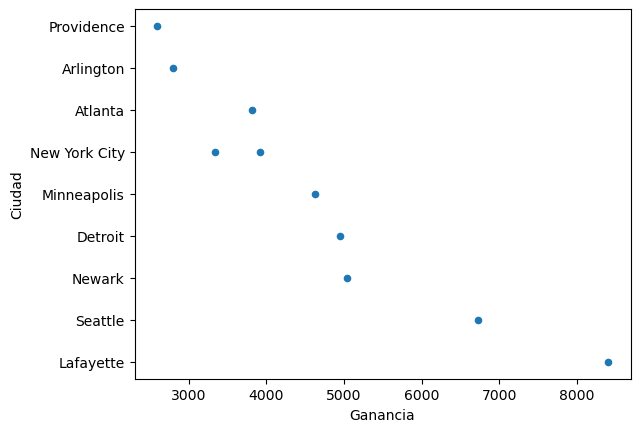

In [52]:
ubicacion_ganancia.plot(x='Ganancia', y='Ciudad', kind='scatter')	

## 2. Cuales son los 10 clientes que generan mas ganancias

In [53]:
sql_query = '''SELECT Fact_super.Id_cliente,Cliente.Nombre, Round(SUM(Ganancia)) AS Ganancia from Fact_super
		INNER JOIN Cliente on Fact_super.Id_cliente = Cliente.Id_cliente
			 Group by Fact_super.Id_cliente, Cliente.Nombre Order by Ganancia DESC LIMIT 10;'''
cliente_ganancia_mayor = pd.read_sql(sql_query, mysql_driver)
cliente_ganancia_mayor.head()

,Id_cliente,Nombre,Ganancia
0,TC-20980,Tamara Chand,9010.0
1,RB-19360,Raymond Buch,6976.0
2,SC-20095,Sanjit Chand,5839.0
3,HL-15040,Hunter Lopez,5622.0
4,AB-10105,Adrian Barton,5484.0


<AxesSubplot:xlabel='Ganancia', ylabel='Nombre'>

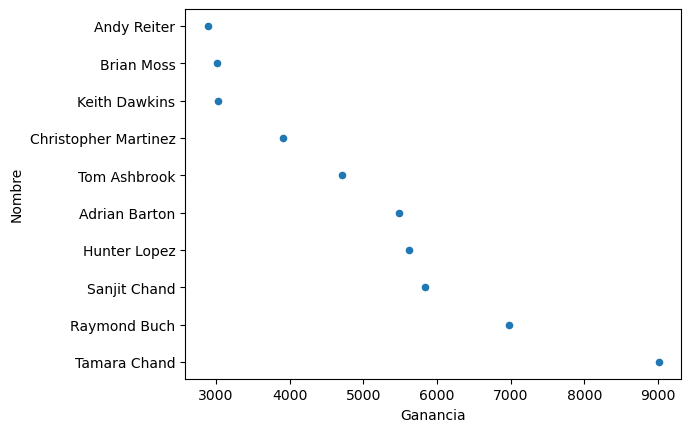

In [54]:
cliente_ganancia_mayor.plot(x='Ganancia', y='Nombre', kind='scatter')	

## 3.Cuales son los 10 productos que generan más ganancias

In [55]:
sql_query = '''SELECT Producto.Nombre, Round(Sum(Fact_super.Ganancia)) AS Ganancia from Fact_super 
    INNER JOIN Producto on Fact_super.Id_producto  = Producto.ID_Product 
    GROUP BY Producto.Nombre Order BY Ganancia DESC LIMIT 10;'''
Prod_ganancia = pd.read_sql(sql_query, mysql_driver)
Prod_ganancia.head()

,Nombre,Ganancia
0,Canon imageCLASS 2200 Advanced Copier,25200.0
1,Fellowes PB500 Electric Punch Plastic Comb Bin...,7753.0
2,Hewlett Packard LaserJet 3310 Copier,6984.0
3,Canon PC1060 Personal Laser Copier,4571.0
4,Plantronics Savi W720 Multi-Device Wireless He...,4492.0


<AxesSubplot:xlabel='Ganancia', ylabel='Nombre'>

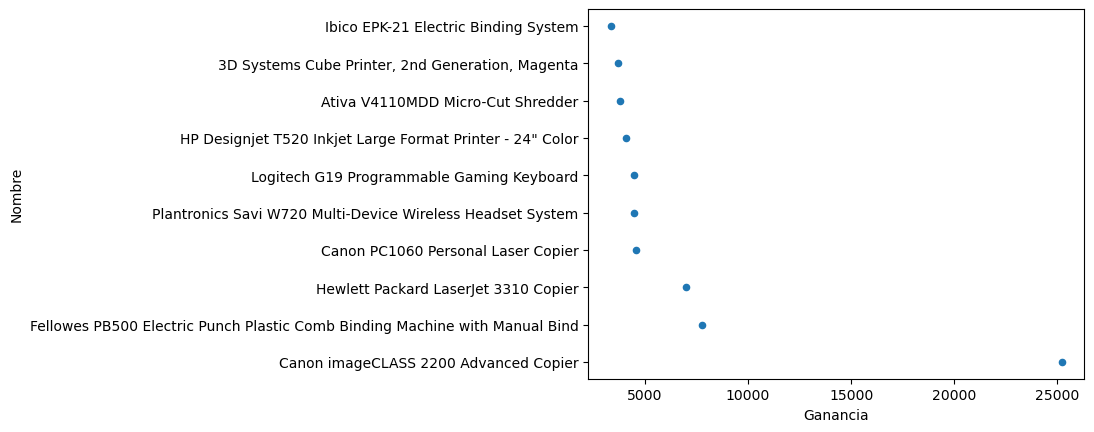

In [56]:
Prod_ganancia.plot(x='Ganancia', y='Nombre', kind='scatter')	

## 4. Cuales son los 10 clientes que generan mas perdidas

In [59]:
sql_query = '''SELECT Fact_super.Id_cliente,Cliente.Nombre, Round(SUM(Ganancia)) AS Ganancia from Fact_super
		INNER JOIN Cliente on Fact_super.Id_cliente = Cliente.Id_cliente
			 Group by Fact_super.Id_cliente, Cliente.Nombre Order by Ganancia ASC LIMIT 10;'''
cliente_ganancia_menor = pd.read_sql(sql_query, mysql_driver)
cliente_ganancia_menor.head()

,Id_cliente,Nombre,Ganancia
0,CS-12505,Cindy Stewart,-6626.0
1,GT-14635,Grant Thornton,-4109.0
2,LF-17185,Luke Foster,-3520.0
3,SR-20425,Sharelle Roach,-3334.0
4,HG-14965,Henry Goldwyn,-2794.0


<AxesSubplot:xlabel='Ganancia', ylabel='Nombre'>

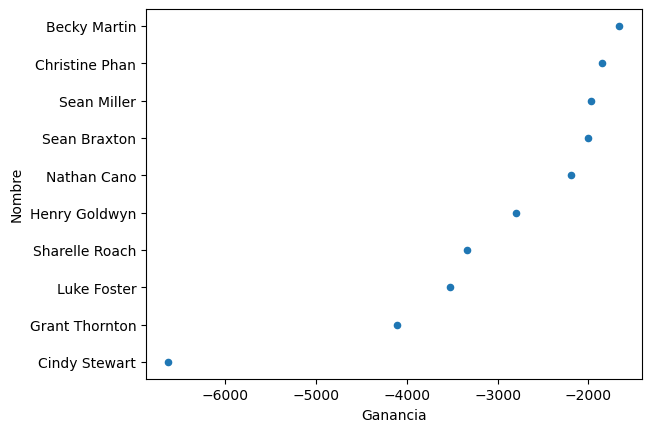

In [60]:
cliente_ganancia_menor.plot(x='Ganancia', y='Nombre', kind='scatter')	

## 5. Cuales son los 10 productos mas vendidos fin de semana con relacion a las ventas entre semana

In [79]:
sql_query = '''SELECT t1.NOMBRE_PRODUCTO, t2.Cantidad_entre_semana as Cant_entre_semana, t1.Cantidad_fin_semana as Cant_fin_de_semana, (t1.Cantidad_fin_semana/t2.Cantidad_entre_semana) AS RATE from
	(SELECT Producto.Nombre as Nombre_Producto, ROUND(SUM(Fact_super.Cantidad)) AS Cantidad_fin_semana  from Fact_super
		INNER JOIN Producto on Fact_super.Id_producto = Producto.ID_Product
		INNER JOIN Fechas_orden on Fact_super.Fecha_orden = Fechas_orden.date_key
		WHERE weekday_flag="Weekend" 
		GROUP BY Nombre_Producto) t1 
		inner join (SELECT Producto.Nombre as Nombre_Producto, ROUND(SUM(Fact_super.Cantidad)) AS Cantidad_entre_semana  from Fact_super
		INNER JOIN Producto on Fact_super.Id_producto = Producto.ID_Product
		INNER JOIN Fechas_orden on Fact_super.Fecha_orden = Fechas_orden.date_key
		WHERE weekday_flag="Weekday" 
		GROUP BY Nombre_Producto) t2 on t1.Nombre_Producto = t2.Nombre_Producto
		ORDER BY RATE DESC LIMIT 10;
        '''
create_rate_cant_fin_de_semana_cant_entre_semana= pd.read_sql(sql_query, mysql_driver)
create_rate_cant_fin_de_semana_cant_entre_semana.head()

,NOMBRE_PRODUCTO,Cant_entre_semana,Cant_fin_de_semana,RATE
0,Imation Secure+ Hardware Encrypted USB 2.0 Fla...,2.0,30.0,15.0
1,Project Tote Personal File,1.0,14.0,14.0
2,Belkin F9M820V08 8 Outlet Surge,1.0,14.0,14.0
3,Cardinal Poly Pocket Divider Pockets for Ring ...,1.0,14.0,14.0
4,Microsoft Wireless Mobile Mouse 4000,1.0,14.0,14.0


<AxesSubplot:xlabel='RATE', ylabel='NOMBRE_PRODUCTO'>

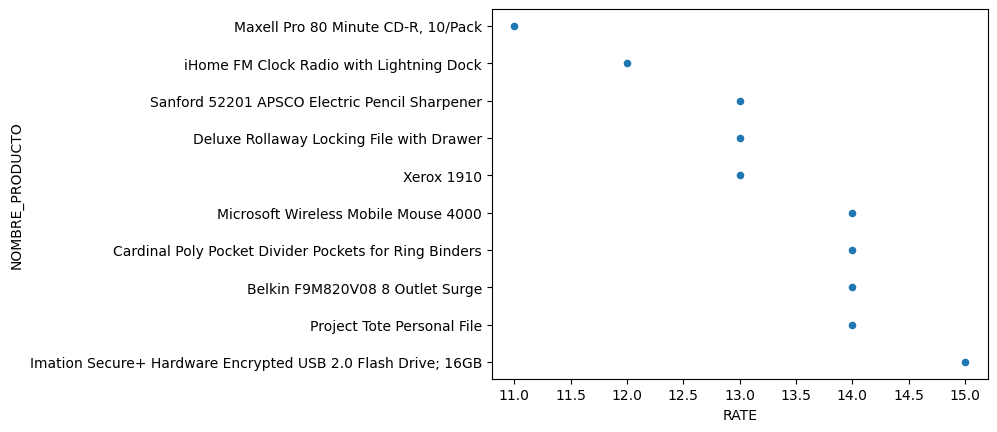

In [80]:
create_rate_cant_fin_de_semana_cant_entre_semana.plot(x='RATE', y='NOMBRE_PRODUCTO', kind='scatter')	

## 6. Cuales son los 10 productos mas vendidos entre semana con relacion a las ventas fin de semana

In [81]:
sql_query = '''	SELECT t1.NOMBRE_PRODUCTO, t2.Cantidad_entre_semana as Cant_entre_semana, t1.Cantidad_fin_semana as Cant_fin_de_semana, (t2.Cantidad_entre_semana/t1.Cantidad_fin_semana) AS RATE from
	(SELECT Producto.Nombre as Nombre_Producto, ROUND(SUM(Fact_super.Cantidad)) AS Cantidad_fin_semana  from Fact_super
		INNER JOIN Producto on Fact_super.Id_producto = Producto.ID_Product
		INNER JOIN Fechas_orden on Fact_super.Fecha_orden = Fechas_orden.date_key
		WHERE weekday_flag="Weekend" 
		GROUP BY Nombre_Producto) t1 
		inner join (SELECT Producto.Nombre as Nombre_Producto, ROUND(SUM(Fact_super.Cantidad)) AS Cantidad_entre_semana  from Fact_super
		INNER JOIN Producto on Fact_super.Id_producto = Producto.ID_Product
		INNER JOIN Fechas_orden on Fact_super.Fecha_orden = Fechas_orden.date_key
		WHERE weekday_flag="Weekday" 
		GROUP BY Nombre_Producto) t2 on t1.Nombre_Producto = t2.Nombre_Producto
		ORDER BY RATE DESC LIMIT 10;
        '''
create_rate_cant_entre_semana_cant_fin_de_semana= pd.read_sql(sql_query, mysql_driver)
create_rate_cant_entre_semana_cant_fin_de_semana.head()

,NOMBRE_PRODUCTO,Cant_entre_semana,Cant_fin_de_semana,RATE
0,3M Hangers With Command Adhesive,32.0,1.0,32.0
1,Logitech Wireless Headset h800,31.0,1.0,31.0
2,"Global Stack Chair with Arms, Black",30.0,1.0,30.0
3,Chromcraft Bull-Nose Wood Oval Conference Tabl...,26.0,1.0,26.0
4,I Need's 3d Hello Kitty Hybrid Silicone Case C...,50.0,2.0,25.0


<AxesSubplot:xlabel='RATE', ylabel='NOMBRE_PRODUCTO'>

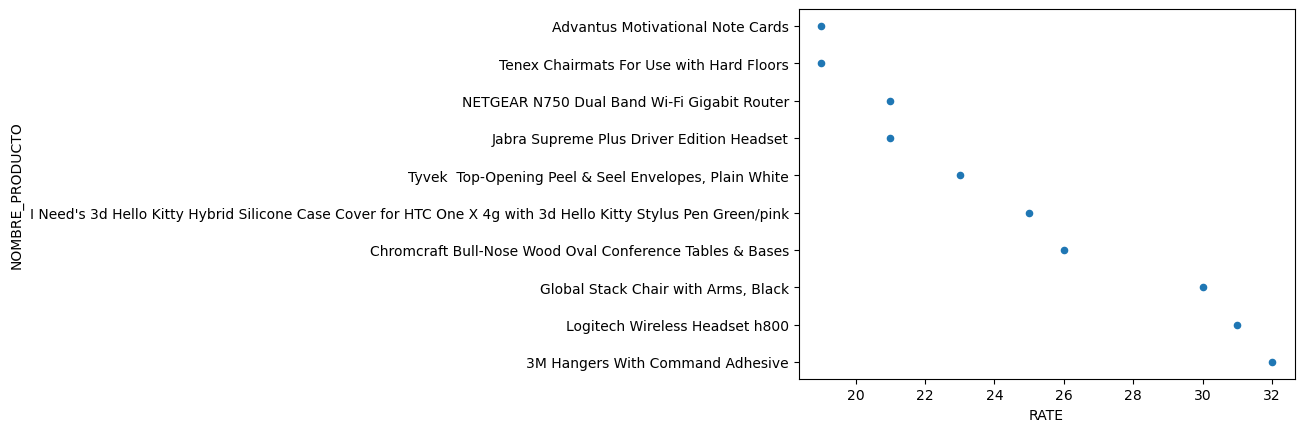

In [82]:
create_rate_cant_entre_semana_cant_fin_de_semana.plot(x='RATE', y='NOMBRE_PRODUCTO', kind='scatter')	